In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 

import acquire as acq
import prepare as prep
import my_model as m

np.random.seed(42)

# Exercises

Create a new notebook, random_forests, and work with titanic data to do the following:

    Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

    Evaluate your results using the model score, confusion matrix, and classification report.

    Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

    Run through steps increasing your min_samples_leaf and decreasing your max_depth.

    What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

After making a few models, which one has the best performance (or closest metrics) on both train and validate?

## Random Forest with titanic

In [2]:
df = acq.get_titanic_data()
df = prep.prep_titanic(df)

csv file found and read


In [3]:
# For modeling I need to only have numbers for my values. sex and embarked have to go
df = df.drop(columns=['sex', 'embarked'])

In [4]:
train, validate, test = prep.split_function(df, 'survived')

Prepared df: (891, 9)

Train: (534, 9)
Validate: (178, 9)
Test: (179, 9)


In [65]:
train.head()

,survived,pclass,sibsp,parch,fare,alone,sex_male,embarked_Q,embarked_S
577,1,1,1,0,55.9000,0,0,0,1
63,0,3,3,2,27.9000,0,1,0,1
424,0,3,1,1,20.2125,0,1,0,1
513,1,1,1,0,59.4000,0,0,0,0
610,0,3,1,5,31.2750,0,0,0,1


#### 0. split into features and target variable

    X will be our features
    y will be our target variable

Also, we want to establish a baseline prediction based on the max of survived.value_counts

In [75]:
# split train, validate, and test into features df (X) and target series (y)
# AND return the baseline accuracy
def get_X_y_baseline(train, validate, test, target):
    """
    This function will
    - take the train, validate, and test dataframes as well as the target variable (string)
    - split the dataframes into X_train/validate/test and y_train/validate/test
    - return all 6 dataframes and the baseline_accuracy rate
    """

    # set X_train/validate/test to be everything but the target
    X_train = train.drop(columns=[target])
    X_validate = validate.drop(columns=[target])
    X_test = test.drop(columns=[target])

    # set y_train/validate/test to be only the target
    y_train = train[target]
    y_validate = validate[target]
    y_test = test[target]

    # Set baseline accuracy
    baseline_accuracy = (train[target] == 0).mean()

    return X_train, X_validate, X_test, y_train, y_validate, y_test, baseline_accuracy

In [5]:
X_train, X_validate, X_test, y_train, y_validate, y_test, baseline_accuracy = (
    m.get_X_y_baseline(train, validate, test, 'survived')
    )

In [6]:
baseline_accuracy

0.6161048689138576

#### 1. make the object

In [7]:
rf = RandomForestClassifier(random_state=42)

#### 2. fit the object
- First I will just send it all the features

In [8]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 3. transform the object

In [9]:
rf.score(X_train, y_train)

0.9307116104868914

In [10]:
y_pred = rf.predict(X_train)
m.get_tree_metrics(y_train, y_pred)

CONFUSION MATRIX
          0_predicted  1_predicted
0_actual          318           11
1_actual           26          179

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       329
           1       0.94      0.87      0.91       205

    accuracy                           0.93       534
   macro avg       0.93      0.92      0.93       534
weighted avg       0.93      0.93      0.93       534

Accuracy: 0.9307116104868914

True Positive Rate/Sensitivity/Recall/Power: 0.8731707317073171
False Positive Rate/False Alarm Ratio/Fall-out: 0.03343465045592705
True Negative Rate/Specificity/Selectivity: 0.9665653495440729
False Negative Rate/Miss Rate: 0.12682926829268293

Precision/PPV: 0.9421052631578948
F1 Score: 0.9063291139240507

Support (0): 205
Support (1): 329


(318, 11, 26, 179)

In [11]:
# After doing everything below, it looks like maybe the default values might be the best, so I just want to 
# check them on the validate set
y_pred_v = rf.predict(X_validate)
m.get_tree_metrics(y_validate, y_pred_v)
# NOPE. It was worse.

CONFUSION MATRIX
          0_predicted  1_predicted
0_actual           96           14
1_actual           22           46

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.68      0.72        68

    accuracy                           0.80       178
   macro avg       0.79      0.77      0.78       178
weighted avg       0.80      0.80      0.79       178

Accuracy: 0.797752808988764

True Positive Rate/Sensitivity/Recall/Power: 0.6764705882352942
False Positive Rate/False Alarm Ratio/Fall-out: 0.12727272727272726
True Negative Rate/Specificity/Selectivity: 0.8727272727272727
False Negative Rate/Miss Rate: 0.3235294117647059

Precision/PPV: 0.7666666666666667
F1 Score: 0.71875

Support (0): 68
Support (1): 110


(96, 14, 22, 46)

- Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [18]:
# This for loop makes multiple RandomForest objects with varying min_samples_leaf and max_depth
# It creates a dataframe with accuracy scores for train and validate, 
# and the difference between them for the various min_samples_leaf and max_depth values

# initialize random forest accuracy dataframe
rf_acc_init = pd.Series(range(1,11))
rf_acc_df = pd.DataFrame(rf_acc_init, columns=['min_samples_leaf'])

for y in range(10, 0, -1): # max_depth = 10-1 
    train_acc_list = []
    val_acc_list = []
    for x in range(1, 11):  # min_samples_leaf = 1-10
        rf = RandomForestClassifier(min_samples_leaf=x, random_state=42, max_depth = y, criterion='entropy')
        rf.fit(X_train, y_train)
        train_acc = rf.score(X_train, y_train)
        val_acc = rf.score(X_validate, y_validate)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
    new_col_t = 'trn_acc_depth_' + str(y)
    rf_acc_df[new_col_t] = pd.Series(train_acc_list)
    new_col_v = 'val_acc_depth_' + str(y)
    rf_acc_df[new_col_v] = pd.Series(val_acc_list)
    new_col_d = 'diff_' + str(y)
    rf_acc_df[new_col_d] = rf_acc_df[new_col_t] - rf_acc_df[new_col_v]

In [17]:
# old_rf_acc_df now has results with criterion='gini'
# old_rf_acc_df = rf_acc_df

# Check Misty's code for a way to visualize this. 
# Might have to visualize one depth at a time or one min_samples_leaf at a time (so 10 graphs)

In [20]:
# this one has results with criterion = 'entropy'.  Looks pretty similar
rf_acc_df

,min_samples_leaf,trn_acc_depth_10,val_acc_depth_10,diff_10,trn_acc_depth_9,val_acc_depth_9,diff_9,trn_acc_depth_8,val_acc_depth_8,diff_8,...,diff_4,trn_acc_depth_3,val_acc_depth_3,diff_3,trn_acc_depth_2,val_acc_depth_2,diff_2,trn_acc_depth_1,val_acc_depth_1,diff_1
0,1,0.928839,0.797753,0.131086,0.919476,0.803371,0.116105,0.906367,0.803371,0.102996,...,0.005618,0.810861,0.820225,-0.009363,0.795880,0.797753,-0.001873,0.756554,0.747191,0.009363
1,2,0.885768,0.820225,0.065543,0.880150,0.825843,0.054307,0.880150,0.808989,0.071161,...,0.009363,0.812734,0.820225,-0.007491,0.795880,0.797753,-0.001873,0.756554,0.747191,0.009363
2,3,0.865169,0.814607,0.050562,0.863296,0.814607,0.048689,0.865169,0.820225,0.044944,...,0.001873,0.808989,0.820225,-0.011236,0.795880,0.797753,-0.001873,0.756554,0.747191,0.009363
3,4,0.861423,0.820225,0.041199,0.865169,0.820225,0.044944,0.855805,0.814607,0.041199,...,-0.007491,0.808989,0.820225,-0.011236,0.794007,0.797753,-0.003745,0.756554,0.747191,0.009363
4,5,0.850187,0.825843,0.024345,0.848315,0.814607,0.033708,0.848315,0.820225,0.028090,...,-0.003745,0.807116,0.820225,-0.013109,0.792135,0.786517,0.005618,0.756554,0.747191,0.009363
5,6,0.848315,0.825843,0.022472,0.846442,0.820225,0.026217,0.846442,0.814607,0.031835,...,-0.005618,0.810861,0.820225,-0.009363,0.790262,0.792135,-0.001873,0.756554,0.747191,0.009363
6,7,0.842697,0.803371,0.039326,0.840824,0.803371,0.037453,0.833333,0.797753,0.035581,...,-0.003745,0.812734,0.831461,-0.018727,0.788390,0.786517,0.001873,0.756554,0.747191,0.009363
7,8,0.825843,0.808989,0.016854,0.831461,0.803371,0.028090,0.825843,0.808989,0.016854,...,-0.007491,0.810861,0.831461,-0.020599,0.788390,0.786517,0.001873,0.752809,0.747191,0.005618
8,9,0.816479,0.808989,0.007491,0.818352,0.803371,0.014981,0.818352,0.814607,0.003745,...,-0.011236,0.807116,0.820225,-0.013109,0.786517,0.780899,0.005618,0.752809,0.747191,0.005618
9,10,0.822097,0.825843,-0.003745,0.822097,0.825843,-0.003745,0.818352,0.820225,-0.001873,...,-0.014981,0.807116,0.825843,-0.018727,0.786517,0.780899,0.005618,0.752809,0.747191,0.005618


In [23]:
drop_columns = ['diff_10','diff_9','diff_8','diff_7','diff_6','diff_5','diff_4','diff_3','diff_2','diff_1']
results_df = rf_acc_df.drop(columns=drop_columns)
results_df.head()

,min_samples_leaf,trn_acc_depth_10,val_acc_depth_10,trn_acc_depth_9,val_acc_depth_9,trn_acc_depth_8,val_acc_depth_8,trn_acc_depth_7,val_acc_depth_7,trn_acc_depth_6,...,trn_acc_depth_5,val_acc_depth_5,trn_acc_depth_4,val_acc_depth_4,trn_acc_depth_3,val_acc_depth_3,trn_acc_depth_2,val_acc_depth_2,trn_acc_depth_1,val_acc_depth_1
0,1,0.928839,0.797753,0.919476,0.803371,0.906367,0.803371,0.895131,0.803371,0.872659,...,0.835206,0.842697,0.831461,0.825843,0.810861,0.820225,0.795880,0.797753,0.756554,0.747191
1,2,0.885768,0.820225,0.880150,0.825843,0.880150,0.808989,0.876404,0.808989,0.868914,...,0.838951,0.837079,0.829588,0.820225,0.812734,0.820225,0.795880,0.797753,0.756554,0.747191
2,3,0.865169,0.814607,0.863296,0.814607,0.865169,0.820225,0.868914,0.814607,0.859551,...,0.831461,0.825843,0.822097,0.820225,0.808989,0.820225,0.795880,0.797753,0.756554,0.747191
3,4,0.861423,0.820225,0.865169,0.820225,0.855805,0.814607,0.855805,0.814607,0.852060,...,0.831461,0.825843,0.823970,0.831461,0.808989,0.820225,0.794007,0.797753,0.756554,0.747191
4,5,0.850187,0.825843,0.848315,0.814607,0.848315,0.820225,0.846442,0.831461,0.848315,...,0.820225,0.808989,0.822097,0.825843,0.807116,0.820225,0.792135,0.786517,0.756554,0.747191


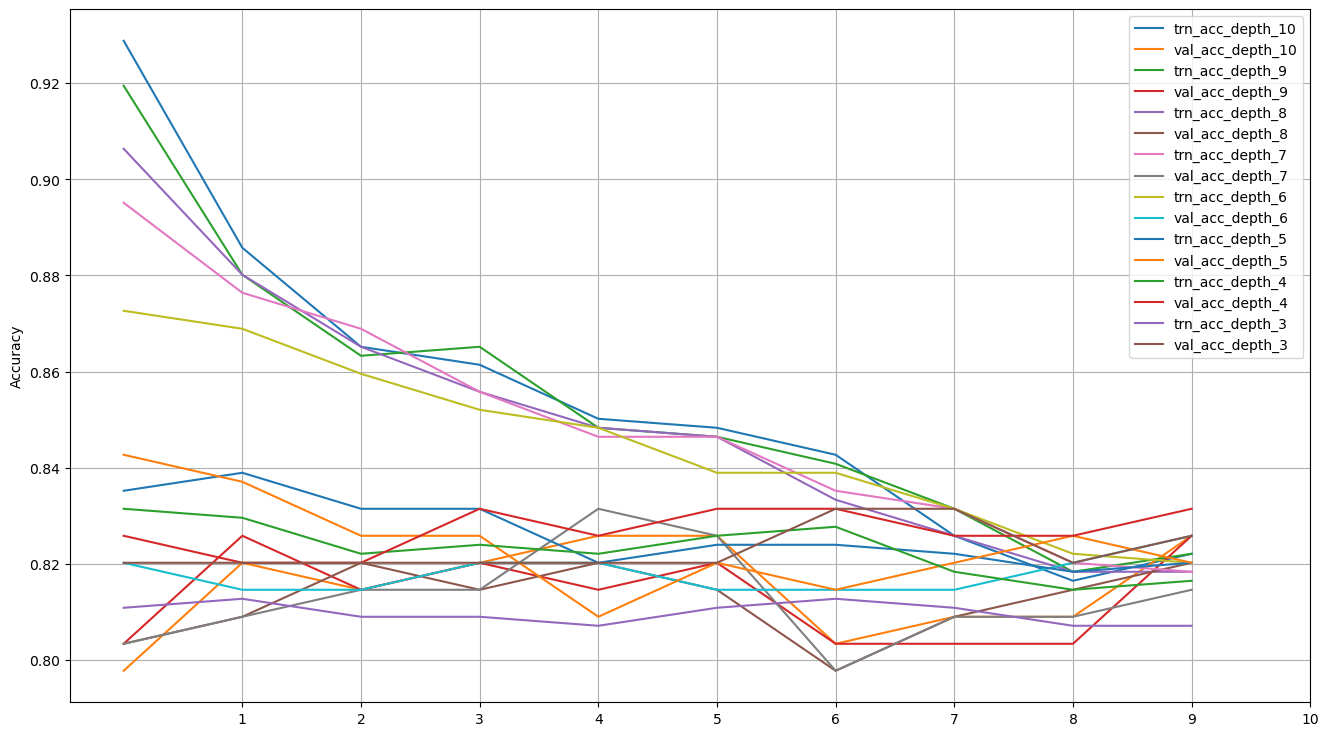

In [27]:
# plot the data
no_plot_cols = ['min_samples_leaf', 'trn_acc_depth_1', 'val_acc_depth_1','trn_acc_depth_2','val_acc_depth_2']
results_df.drop(columns=no_plot_cols).plot(figsize = (16,9))
# results_df.plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,11))
plt.grid()

In [13]:
# ~ the best accuracy was min_leaf_samples of 10 and max_depth of 9
# However, that is a little subjective. I'm gong to search for some way to choose
# the best RF classifier with metrics.

rf = RandomForestClassifier(min_samples_leaf=10, max_depth=9, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=10, random_state=42)

In [14]:
y_pred = rf.predict(X_train)
m.get_tree_metrics(y_train, y_pred)

temp = rf.predict_proba(X_train)
# I'm not sure what the value of proba is. The result is an array with predicted chance of 0/1 (die/survive) 
# for each row of our dataset (X_train in this case).

CONFUSION MATRIX
          0_predicted  1_predicted
0_actual          301           28
1_actual           67          138

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       329
           1       0.83      0.67      0.74       205

    accuracy                           0.82       534
   macro avg       0.82      0.79      0.80       534
weighted avg       0.82      0.82      0.82       534

Accuracy: 0.8220973782771536

True Positive Rate/Sensitivity/Recall/Power: 0.6731707317073171
False Positive Rate/False Alarm Ratio/Fall-out: 0.0851063829787234
True Negative Rate/Specificity/Selectivity: 0.9148936170212766
False Negative Rate/Miss Rate: 0.32682926829268294

Precision/PPV: 0.8313253012048193
F1 Score: 0.7439353099730458

Support (0): 205
Support (1): 329


In [16]:
# let's look at validate
y_pred = rf.predict(X_validate)
m.get_tree_metrics(y_validate, y_pred)

CONFUSION MATRIX
          0_predicted  1_predicted
0_actual          102            8
1_actual           23           45

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       110
           1       0.85      0.66      0.74        68

    accuracy                           0.83       178
   macro avg       0.83      0.79      0.81       178
weighted avg       0.83      0.83      0.82       178

Accuracy: 0.8258426966292135

True Positive Rate/Sensitivity/Recall/Power: 0.6617647058823529
False Positive Rate/False Alarm Ratio/Fall-out: 0.07272727272727272
True Negative Rate/Specificity/Selectivity: 0.9272727272727272
False Negative Rate/Miss Rate: 0.3382352941176471

Precision/PPV: 0.8490566037735849
F1 Score: 0.7438016528925621

Support (0): 68
Support (1): 110


(102, 8, 23, 45)